## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Валинуров Денис Юрьевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

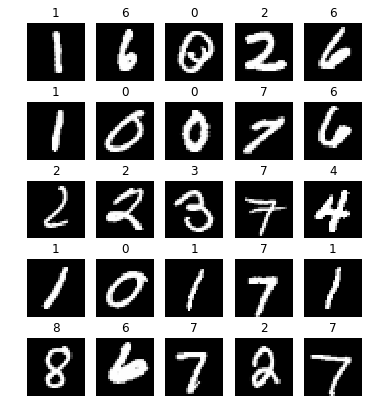

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def init_layer_xavier(layer, n_i, n_i1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    border = np.sqrt(6.0/float(n_i + n_i1))
    weight.uniform_(-border, border)
    
def init_layer_he(layer, n_i):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=np.sqrt(2.0/float(n_i)))
    
def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print 'forward', std

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().data[0]
    print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
def new_linear_layer(input_size, output_size, mean, std):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

def new_linear_layer_he(input_size, output_size, mean=None, std=None):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer_he(layer, output_size)
    return layer

def new_linear_layer_xavier(input_size, output_size, mean=None, std=None):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer_xavier(layer, input_size, output_size)
    return layer

In [8]:
def check(activ, init):
    layers = []
    mean = 0
    std = 0.1
    layers.append(init(784, 500, mean=0, std=0.1))
    layers.append(activ())
    for i in range(10):
        layers.append(init(500, 500, mean=0, std=0.1))
        layers.append(activ())
    layers.append(init(500, 10, mean=0, std=0.1))
    layers.append(nn.LogSoftmax())
    network = nn.Sequential(*layers)
    
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [9]:
#пример:
check(nn.Tanh, new_linear_layer)

forward 1.01361370087
forward 0.850205600262
forward 0.788460850716
forward 0.770619928837
forward 0.767612278461
forward 0.766273081303
forward 0.76556456089
forward 0.762799859047
forward 0.76237988472
forward 0.763826131821
forward 0.764725446701
forward 0.764507234097
backward 0.00340207270347
backward 0.0005830101436
backward 0.000697556359228
backward 0.000841383764055
backward 0.00102485739626
backward 0.0012436005054
backward 0.00150202831719
backward 0.00181161204819
backward 0.00217076204717
backward 0.00260100117885
backward 0.00302198040299
backward 0.00296336435713


/home/denis/anaconda2/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [10]:
check(nn.ReLU, new_linear_layer)

forward 1.01361370087
forward 1.66055762768
forward 2.58283543587
forward 4.00995111465
forward 6.4682135582
forward 10.4470472336
forward 16.3510379791
forward 25.9152736664
forward 41.5093574524
forward 66.9494628906
forward 100.970352173
forward 143.487243652
backward 0.00424469588324
backward 0.00100021006074
backward 0.00161063484848
backward 0.00264112232253
backward 0.00427203858271
backward 0.00677154120058
backward 0.0109497411177
backward 0.0174194201827
backward 0.027340779081
backward 0.0436417870224
backward 0.0696337670088
backward 0.111527353525


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [11]:
check(nn.Tanh, new_linear_layer_he)

forward 1.01361370087
forward 0.771447479725
forward 0.649965643883
forward 0.603715777397
forward 0.578466832638
forward 0.567733585835
forward 0.562885701656
forward 0.557427585125
forward 0.55363625288
forward 0.551768898964
forward 0.551865041256
forward 0.552202939987
backward 0.00387295149267
backward 0.00415901653469
backward 0.00440379651263
backward 0.00459117814898
backward 0.00483205541968
backward 0.00510331708938
backward 0.00536678731441
backward 0.00558234006166
backward 0.00576029112563
backward 0.00575315393507
backward 0.00535300653428
backward 0.00403775414452


In [12]:
check(nn.ReLU, new_linear_layer_he)

forward 1.01361370087
forward 1.08009874821
forward 1.0725748539
forward 1.01474010944
forward 1.07124304771
forward 1.03953170776
forward 1.04253435135
forward 0.984588027
forward 1.0130841732
forward 0.960484027863
forward 0.978224515915
forward 0.929307222366
backward 0.00392279680818
backward 0.00387757713906
backward 0.00396264623851
backward 0.00381819624454
backward 0.0038456574548
backward 0.00376277859323
backward 0.0038124138955
backward 0.00369222229347
backward 0.00371184642427
backward 0.00361118442379
backward 0.00365402037278
backward 0.00367270549759


In [13]:
check(nn.Tanh, new_linear_layer_xavier)

forward 1.01361370087
forward 0.652355492115
forward 0.500133872032
forward 0.415752261877
forward 0.362657159567
forward 0.321134418249
forward 0.293498396873
forward 0.270405769348
forward 0.253692448139
forward 0.239168256521
forward 0.229091733694
forward 0.218077138066
backward 0.00300699658692
backward 0.000574127305299
backward 0.000535432132892
backward 0.000499335583299
backward 0.000472341023851
backward 0.000438738963567
backward 0.000397214200348
backward 0.000365214102203
backward 0.000319642160321
backward 0.000273428187938
backward 0.000209161109524
backward 0.000138259725645


In [14]:
check(nn.ReLU, new_linear_layer_xavier)

forward 1.01361370087
forward 0.636584043503
forward 0.427280366421
forward 0.289574474096
forward 0.217143416405
forward 0.156841784716
forward 0.118883594871
forward 0.0788791030645
forward 0.0523021668196
forward 0.0376477390528
forward 0.0262027885765
forward 0.018183561042
backward 0.00300137861632
backward 0.000403043377446
backward 0.00028525700327
backward 0.000195327564143
backward 0.000135320529807
backward 9.56548828981e-05
backward 6.99629599694e-05
backward 5.10055797349e-05
backward 3.68298460671e-05
backward 2.64222635451e-05
backward 1.85023181984e-05
backward 1.28473484438e-05


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [15]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

In [16]:
network_out = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

In [17]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+(1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

In [18]:
network_connect = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

Epoch 9... (Train/Test) NLL: 0.019/0.078	Accuracy: 0.994/0.980

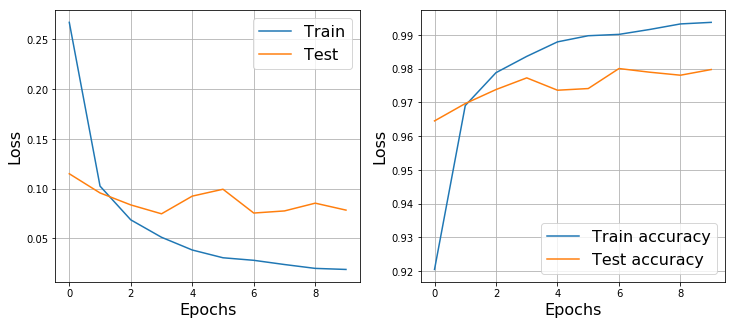

Epoch 9... (Train/Test) NLL: 0.122/0.074	Accuracy: 0.963/0.978

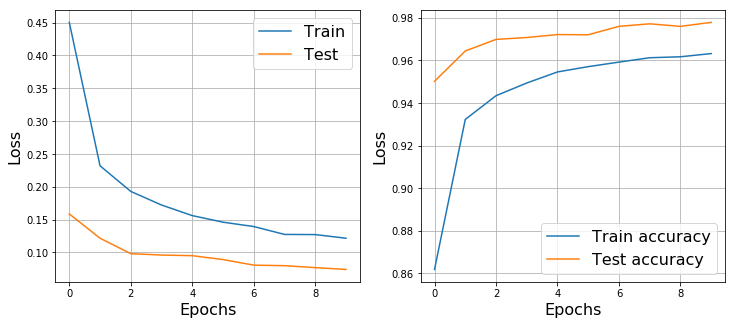

Epoch 9... (Train/Test) NLL: 0.081/0.066	Accuracy: 0.973/0.979

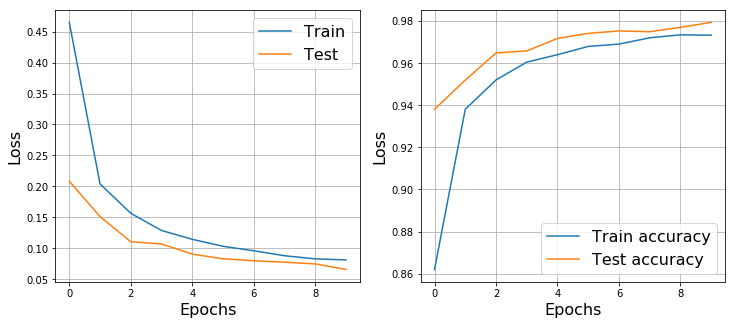

In [19]:
train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

train_utils.train(network_out, train_loader, test_loader, 10, 0.001, ravel_init=True)

train_utils.train(network_connect, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по третьей части </i>

На графиках по кривым теста видно, что DropOut и DropConnect помогают предотвращать переобучение. DropConnect показал результаты лучше, чем DropOut.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [27]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim, mean=0, std=0.01):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.Tensor(1, input_dim).fill_(1.0), requires_grad=True)
        self.beta = nn.Parameter(torch.Tensor(1, input_dim).normal_(mean=mean, std=std), requires_grad=True)
        
    def forward(self, x):
        output = self.gamma * (x - x.mean(1, True)) / x.std(1, True) + self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [28]:
batch_model = nn.Sequential(nn.Linear(784, 200),
                        torch.nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        torch.nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

In [29]:
layer_model = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

Epoch 9... (Train/Test) NLL: 0.015/0.069	Accuracy: 0.995/0.981

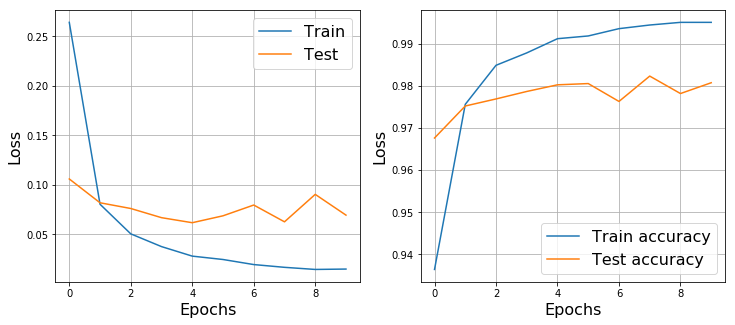

Epoch 9... (Train/Test) NLL: 0.018/0.074	Accuracy: 0.994/0.981

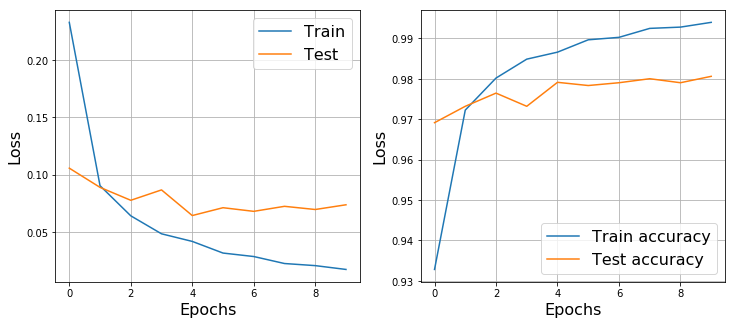

In [30]:
train_utils.train(batch_model, train_loader, test_loader, 10, 0.001, ravel_init=True)

train_utils.train(layer_model, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: